In [13]:
import glob
import random

from keras.applications import EfficientNetB0
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import datasets, layers, models
from keras.applications.efficientnet import preprocess_input
from keras.callbacks import EarlyStopping

In [14]:
washington_data = pd.DataFrame([file for file in glob.iglob("../data/**/*.jpg", recursive=True)])
washington_data = pd.DataFrame(washington_data[0])
washington_data['image_data'] = washington_data[0].apply(lambda x : np.asarray(Image.open(x)))
# Change file system parsing to be mac-friendly
washington_data[[0, 1, 'parent_file_path', 'name','image_id']] = washington_data[0].str.split("/", expand = True)[[0,1,2,3,4]]
print(washington_data)

       0                                         image_data     1  \
0     ..  [[[125, 167, 243], [121, 163, 239], [115, 158,...  data   
1     ..  [[[29, 16, 44], [40, 28, 50], [33, 25, 36], [2...  data   
2     ..  [[[98, 101, 106], [108, 111, 116], [119, 122, ...  data   
3     ..  [[[79, 86, 96], [80, 87, 97], [81, 88, 98], [8...  data   
4     ..  [[[66, 76, 86], [67, 77, 87], [68, 78, 88], [7...  data   
...   ..                                                ...   ...   
4620  ..  [[[149, 202, 244], [149, 202, 244], [149, 202,...  data   
4621  ..  [[[167, 190, 204], [175, 198, 212], [179, 202,...  data   
4622  ..  [[[220, 227, 233], [220, 227, 233], [220, 227,...  data   
4623  ..  [[[12, 64, 199], [13, 65, 200], [15, 67, 202],...  data   
4624  ..  [[[226, 227, 229], [226, 227, 229], [226, 227,...  data   

     parent_file_path                                   name  \
0              Images  Redondo Beach, Des Moines, Washington   
1              Images  Redondo Beach, Des M

In [15]:
washington_data_cleaned = washington_data[['name', 'image_id', 'image_data']]
print(washington_data_cleaned)

                                       name              image_id  \
0     Redondo Beach, Des Moines, Washington  fb4e60c89208fa17.jpg   
1     Redondo Beach, Des Moines, Washington  c7ef5dadf1372bf1.jpg   
2     Redondo Beach, Des Moines, Washington  bc48f76ef39e0d0d.jpg   
3     Redondo Beach, Des Moines, Washington  3b0667738a4bccc7.jpg   
4     Redondo Beach, Des Moines, Washington  6e2bba4bd85e650a.jpg   
...                                     ...                   ...   
4620               Lenore Lake (Washington)  0096ddca55c7058a.jpg   
4621               Lenore Lake (Washington)  b4e3c66492af9a0a.jpg   
4622               Lenore Lake (Washington)  32279bb54e244c9c.jpg   
4623               Lenore Lake (Washington)  a9047a6b069c970d.jpg   
4624               Lenore Lake (Washington)  b48c6e5e197c3840.jpg   

                                             image_data  
0     [[[125, 167, 243], [121, 163, 239], [115, 158,...  
1     [[[29, 16, 44], [40, 28, 50], [33, 25, 36], [2...

In [16]:
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(pd.DataFrame(washington_data_cleaned['name']))

labels_onehot = encoder.transform(pd.DataFrame(washington_data_cleaned['name'])).toarray()

In [17]:
washington_images_stack = np.stack(washington_data_cleaned['image_data'], axis=0)

In [18]:
x_train, x_test, y_train, y_test = train_test_split(washington_images_stack, labels_onehot, test_size=0.2)

In [19]:
x_train, x_val, y_train, y_val = train_test_split(
x_train, y_train, test_size=0.2
) # 0.16 = validation set

In [20]:
num_classes = len(washington_data_cleaned['name'].unique())
dropout_rate = 0.3
img_dimension = (224, 224, 3)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomBrightness(0.1),
    layers.RandomContrast(0.1)
], name="data_augmentation")

# takes input data, augments, and preps it for EfficientNetB0
inputs = layers.Input(shape=img_dimension)
x = data_augmentation(inputs) 
x = preprocess_input(x)

# preps EfficientNetB0 model (with its weights) to train with our model
base_model = EfficientNetB0(include_top=False, input_tensor=None, weights='imagenet')
base_model.trainable = False

# layers to train the model with our data
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)

x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout_rate)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
auc_metric = tf.keras.metrics.AUC(multi_label=True)
top_five_accuracy_metric = tf.keras.metrics.TopKCategoricalAccuracy(k=5)

EPOCHS = 50
BATCH_SIZE = 64

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy', auc_metric, top_five_accuracy_metric])

history = model.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data = (x_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 31s 566ms/step - accuracy: 0.1051 - auc_2: 0.4743 - loss: 5.5097 - top_k_categorical_accuracy: 0.1908 - val_accuracy: 0.4176 - val_auc_2: 0.5950 - val_loss: 4.1018 - val_top_k_categorical_accuracy: 0.6365
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 539ms/step - accuracy: 0.4455 - auc_2: 0.7023 - loss: 2.5747 - top_k_categorical_accuracy: 0.6879 - val_accuracy: 0.5473 - val_auc_2: 0.6640 - val_loss: 3.1669 - val_top_k_categorical_accuracy: 0.7784
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 26s 547ms/step - accuracy: 0.6175 - auc_2: 0.7795 - loss: 1.6416 - top_k_categorical_accuracy: 0.8497 - val_accuracy: 0.6122 - val_auc_2: 0.6839 - val_loss: 2.4435 - val_top_k_categorical_accuracy: 0.8297
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 543ms/step - accuracy: 0.7149 - auc_2: 0.7894 - loss: 1.1809 - top_k_categorical_accuracy: 0.9158 - val_accuracy: 0.6649 - val_auc_2: 0.6892 - val_loss: 1.9283 - val_top_k_categorical_accuracy: 0.8676
Epoch 5/50
47/47 ━━━━━━━━━━━

In [23]:
model.save('224x224 image classification EfficientNetB0 Train Split.keras')

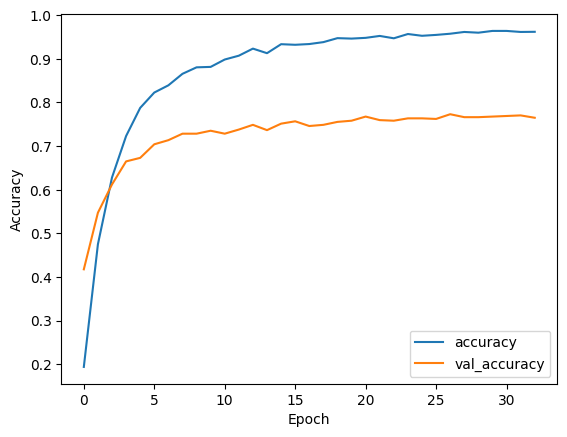

In [24]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

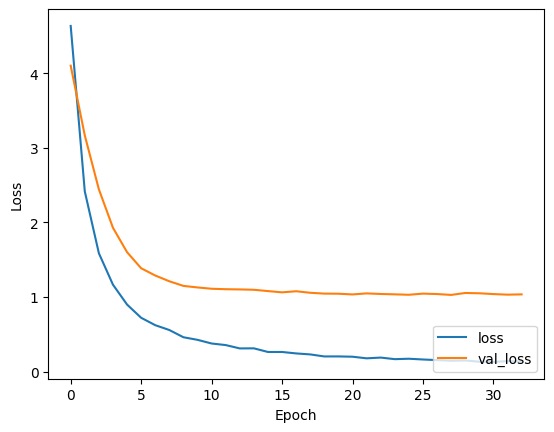

In [25]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.show()

dict_keys(['accuracy', 'auc_2', 'loss', 'top_k_categorical_accuracy', 'val_accuracy', 'val_auc_2', 'val_loss', 'val_top_k_categorical_accuracy'])


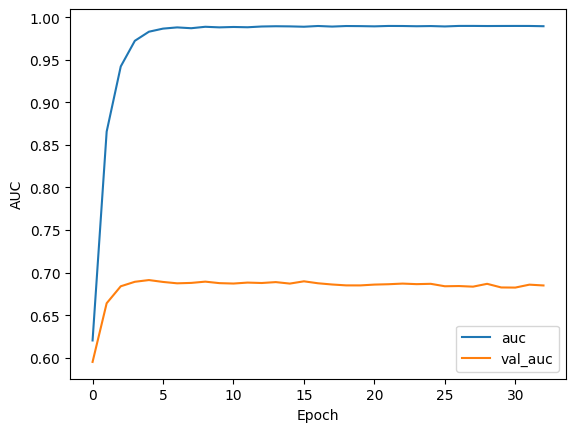

In [30]:
print(history.history.keys())
plt.plot(history.history['auc_2'], label='auc')
plt.plot(history.history['val_auc_2'], label = 'val_auc')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(loc='lower right')

plt.show()

In [32]:
model = tf.keras.models.load_model("224x224 image classification EfficientNetB0 Train Split.keras")

In [141]:
from skimage.transform import resize

def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="uint8" )
    return data

img_needle = load_image("IMG_3367.jpg")
img_chinatown = load_image("IMG_5020.jpg")
img_library = load_image("img_2377.jpg")
img_fountain = load_image("fountain.jpg")

img_needle_resized = resize(np.array(img_needle), (224, 224, 3), anti_aliasing=True)
img_chinatown_resized = resize(np.array(img_chinatown), (224, 224, 3), anti_aliasing=True)
img_library_resized = resize(np.array(img_library), (224, 224, 3), anti_aliasing=True)
img_fountain_resized = resize(np.array(img_fountain), (224, 224, 3), anti_aliasing=True)

img_needle_resized = preprocess_input(img_needle_resized * 255).astype(int)
img_chinatown_resized = preprocess_input(img_chinatown_resized * 255).astype(int)
img_library_resized = preprocess_input(img_library_resized * 255).astype(int)
img_fountain_resized = preprocess_input(img_fountain_resized * 255).astype(int)

image_batch = np.array([img_needle_resized, img_chinatown_resized, img_library_resized, img_fountain_resized])

output = model.predict(image_batch)
output

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


array([[3.3969414e-08, 1.7563530e-05, 1.3556766e-07, ..., 1.1905295e-08,
        3.0484678e-08, 9.6688488e-08],
       [8.8869392e-06, 1.5774441e-04, 9.0540116e-06, ..., 1.8421244e-05,
        1.5562266e-07, 6.1730840e-05],
       [1.6748865e-05, 4.4743408e-04, 1.4267340e-05, ..., 2.1573778e-05,
        4.9871483e-05, 3.8678638e-05],
       [1.1588324e-09, 7.3267423e-09, 1.2804750e-07, ..., 2.6762462e-08,
        2.7685387e-09, 1.4436301e-08]], dtype=float32)

In [142]:
classes = washington_data_cleaned['name'].unique()

for picture in output:
    guesses = np.argsort(picture)[-5:]
    print(np.round(picture[guesses][::-1], 3))

    for guess in guesses[::-1]:
        print(classes[guess])
        
    print("----------")

[1. 0. 0. 0. 0.]
Dome Peak
Riverfront Park Carousel
Pier 55, Seattle, Washington
Freeway Park, Seattle
Fort Lawton
----------
[0.301 0.252 0.174 0.073 0.063]
Manito Park
Duwamish Head
Fort Worden
South Park Bridge
United Presbyterian Church (Pullman, Washington)
----------
[0.354 0.14  0.128 0.115 0.064]
South Park Bridge
Browns Point Light
First Presbyterian Church, Tacoma, Washington
Starbucks Coffee in Pike Place Market
Belltown, Seattle, Washington
----------
[0.998 0.001 0.    0.    0.   ]
South Lake Union, Seattle, Washington
Lake Washington
Bothell Pioneer Cemetery
Pier 57, Seattle, Washington
Mount Shuksan
----------


# TEST IMAGE ONE
SPACE NEEDLE

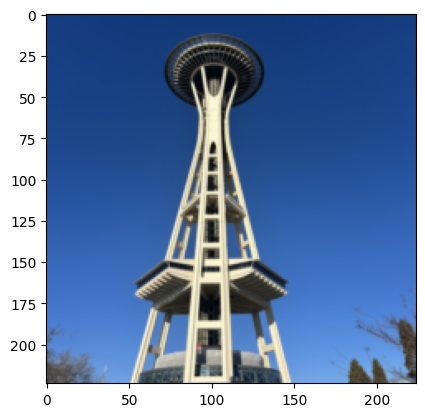

In [139]:
plt.imshow(img_needle_resized)

# TEST IMAGE TWO
INTERNATIONAL DISTRICT

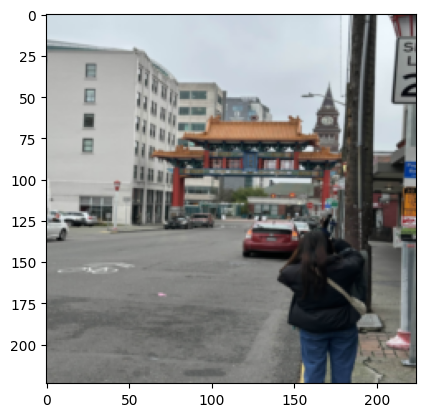

In [26]:
plt.imshow(img_chinatown_resized)

# TEST IMAGE THREE
SUZZALO LIBRARY (UW)

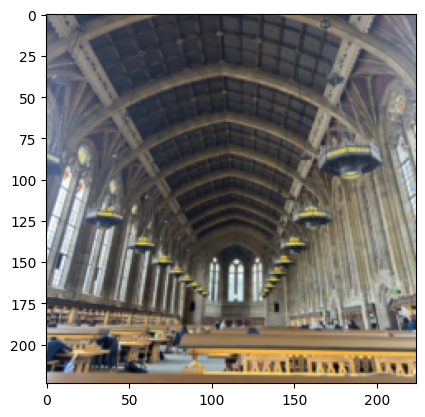

In [27]:
plt.imshow(img_library_resized)

# TEST IMAGE FOUR
Drumheller Fountain (UW)

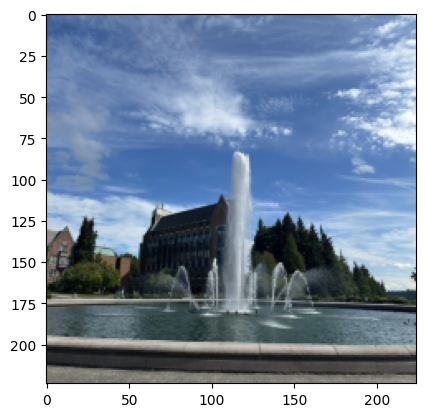

In [29]:
plt.imshow(img_fountain_resized)

# TESTING: 


In [109]:
test_output = model.predict(x_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step


In [135]:
# x_test: numpy array of pixel values: 
# y_test: numpy array of one-hot encoded label
# test_output: array of arrays that contain probabilities for each label
index = 0 
num_correct = 0
for one_test_output in test_output: 
    guesses = np.argsort(one_test_output)[-5:]
    print(np.round(one_test_output[guesses][::-1], 3))
    actual_test_label_index = np.argmax(y_test[index])
    actual_label = classes[actual_test_label_index]
    print("ACTUAL LABEL: ", actual_label)
    prioritized_guesses = guesses[::-1]
    guess_labels = [1,1,1,1,1]
    for i in range(0,5):
        guess_labels[i] = classes[prioritized_guesses[i]]
        
    print("----------")
    print(guess_labels)
    print(guesses[::-1])
    if actual_label in guess_labels:
        num_correct += 1
    
    index +=1 
    
test_len = len(x_test)
print(num_correct)
print(num_correct/test_len)
    
# print(test_output[0])
# print(x_test[0])

[0.995 0.003 0.    0.    0.   ]
ACTUAL LABEL:  International District, Seattle, Washington
----------
['International District, Seattle, Washington', 'Evergreen Speedway', 'Occidental Park', 'Westlake Park (Seattle)', 'Langston Hughes Performing Arts Center']
[124  76 172 289 144]
[0.984 0.003 0.002 0.001 0.001]
ACTUAL LABEL:  1611 Everett Avenue, Everett, Washington
----------
['1611 Everett Avenue, Everett, Washington', 'Pioneer Square, Seattle, Washington', 'Belltown, Seattle, Washington', 'Frank B. Cooper School', 'Elks Temple (Tacoma, Washington)']
[  2 192  25  90  73]
[1. 0. 0. 0. 0.]
ACTUAL LABEL:  Occidental Park
----------
['Occidental Park', 'Starbucks Coffee in Pike Place Market', 'Seattle Japanese Garden', 'Hing Hay Park', 'Evergreen Speedway']
[172 246 227 112  76]
[0.858 0.12  0.015 0.002 0.001]
ACTUAL LABEL:  Rainier Tower
----------
['Rainier Tower', 'Amazon Tower I', 'Seattle Art Museum', 'Smith Tower (Seattle)', 'Henry M. Jackson Federal Building']
[203  11 218 235 1

'1611 Everett Avenue, Everett, Washington'